In [7]:
# Metrics
import os
import pandas as pd
import numpy as np
from itertools import zip_longest
import re
import matplotlib.pyplot as plt

import matplotlib.ticker as tkr  

def numfmt(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 100000)
    return s

yfmt = tkr.FuncFormatter(numfmt)

def numfmt2(x, pos): # your custom formatter function: divide y axis tick labels by 1000.0
    s = '{}'.format(x / 1000)
    return s
yfmt2 = tkr.FuncFormatter(numfmt2)

def numfmt3(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 10000000)
    return s
yfmt3 = tkr.FuncFormatter(numfmt3)

def numfmt4(x, pos): # your custom formatter function: multiply y axis tick labels by 100.0
    s = '{}'.format(x * 100)
    return s
yfmt4 = tkr.FuncFormatter(numfmt4)

def minutes(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 60000)
    return s

def ms_to_sec(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 1000)
    return s

def sec_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60)
    return s

In [8]:
# rcParams

plt.rcParams["figure.autolayout"] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Functions

In [9]:
def plot_evolution_dicts(throughput_dict):
    x = sorted(throughput_dict.keys())
    y = list()
    fig, ax = plt.subplots(len(x))
    fig.set_size_inches(30.5, 30.5)
    for i,key in enumerate(x):  
        ax[i].plot(throughput_dict[key][0])
        ax[i].set_xlabel("Parallelism: %s" % key)
        ax[i].ticklabel_format(style='plain',useOffset=False)
    plt.show()

In [28]:
def transform_parallel_to_machines(throughput_dict):
    a = {}
    for i,j in throughput_dict.items():
        a[round(i/10)] = j
    return a

In [10]:
def get_aggregated_throughput(entry_folder_name="metrics", operator_name="GNN Operator - 2", metric_name="numRecordsInPerSecond", agg="concat", is_lambda=False):
    throughput_dict = {}
    for i in os.listdir(entry_folder_name):
        if not os.path.isdir(os.path.join(entry_folder_name, i)):
            continue
        agg_value = list() if agg == "concat" else 0
        for j in os.listdir(os.path.join(entry_folder_name, i, operator_name, metric_name)):
            if not j.isdigit():
                continue
            f = pd.read_csv(os.path.join(entry_folder_name, i, operator_name, metric_name,j), header=None, names=["value"])
            # f = f[f["value"] > 0]
            if f.empty:
                print(f, j,i)
                continue
            if agg == "max":
                agg_value += float(f.max())
            elif agg == "mean":
                agg_value += float(f.mean())
            elif agg == "concat":
                agg_value.append(f["value"].tolist()) # Nested list operator -> List of values
                
        parallelism = int(re.match(".*\((\d+)\).*",i).groups()[0]) if not is_lambda else float(re.match(".*-l=(\d+.\d+).*",i).groups()[0])
        if parallelism not in throughput_dict:
            throughput_dict[parallelism] = [agg_value]
        else:
            throughput_dict[parallelism].append(agg_value)
    return throughput_dict

In [31]:
def plot_aggregated_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=yfmt, ylabel="Throughput ($x 10^5$ operations/s)", xlabel="Parallelism", pre_fig=None):
    x = np.array(sorted(inputs[0].keys()))
    y = list(map(lambda x: np.array([]), inputs))
    lines = list()
    for key in x:
        for i, _ in enumerate(y):
            if key not in inputs[i]:
                inputs[i][key] = 0
            val = np.array(inputs[i][key])
            y[i] = np.append(y[i], val)
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    for i, yi in enumerate(y):
        if fit_degree:
            theta = np.poly1d(np.polyfit(x, y[i], fit_degree))
            fit_line = theta(x)
            lines.append(ax.scatter(x,yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
            lines.append(ax.plot(x,fit_line, label=None, marker=None, linestyle=":")[0])
            
        else:
            lines.append(ax.plot(x,yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i])[0])
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)


def plot_evolution_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=yfmt, ylabel="Throughput ($x 10^5$ operations/s)", xlabel="Parallelism", pre_fig=None):
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    lines = list()
    for i,x in enumerate(inputs):

        for key, values in x.items():
            if fit_degree:
                theta = np.poly1d(np.polyfit(x, values, fit_degree))
                fit_line = theta(x)
                lines.append(ax.scatter(values, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
                lines.append(ax.plot(fit_line, label=None, marker=None, linestyle=":")[0])
            else:
                print(key)
                lines.append(ax.plot(range(len(values)),values, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)

        

In [12]:
def agg_concat_list(values, agg_sub_op="sum", agg=None):
    """ Values are parallelism -> Experiment -> SubOperator -> List of values """
    new_one = dict()
    global tmp_exp
    global exp_values
    for parallelism, exps in values.items():
        tmp_exp = list()
        for exp in exps:
            exp_values = list(map(lambda x: np.array(x), exp))
            max_len = max([len(x) for x in exp_values])
            exp_values = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in exp_values])
            if agg_sub_op=="sum":
                tmp_exp.append(exp_values.sum(axis=0)) # Sum across sub operators
            elif agg_sub_op == "mean":
                tmp_exp.append(np.nanmean(np.where(exp_values == 0, np.nan, exp_values), axis=0)) # Sum across sub operators

        max_len = max([len(x) for x in tmp_exp])
        tmp_exp = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in tmp_exp])
        tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)
        if agg == None:
            new_one[parallelism] = tmp_exp_mean
        elif agg == "max":
            new_one[parallelism] = np.nanmax(tmp_exp)
        elif agg == "min":
            new_one[parallelism] = np.nanmin(tmp_exp)
        elif agg == "maxlog":
            new_one[parallelism] = np.log2(np.nanmax(tmp_exp))
        elif agg == "meanmax":
            new_one[parallelism] = np.nanmax(tmp_exp_mean)
        elif agg == "mean":
            new_one[parallelism] = np.nanmean(tmp_exp_mean)
        elif agg == "last_nonzero":
            new_one[parallelism] = tmp_exp_mean[np.nonzero(tmp_exp_mean)[0].max()]
        elif agg == "len_nonzero":
            min_len = float("inf")
            for i in tmp_exp:
                s = np.nonzero(i)[0]
                if len(s) < 2:
                    min_len = min(min_len, 1)
                else:
                    min_len = min(min_len, s.max() - s.min())
            new_one[parallelism] = min_len
    return new_one

# DGL Static Data

In [58]:
DGL_STREAMING_MEAN_THROUGHPUT = {
    1: 1331.4602295942798,
    2: 1269.7330430416148,
    3: 1421.77909239933595,
    4: 1621.19888063197420,
    5: 1744.10098713768392,
    6: 809.42342148774028,
    7: 1869.26679840645398,
    8: 1890.72653656091697,
    9: 1890.51182274839784,
    10: 1890.51182274839784
    
}

DGL_STREAMING_MAX_THROUGHPUT = {
    1: 10256.782945736435,
    2: 9746.0803748423136,
    3: 11081.596802797604,
    4: 13112.9238276952765,
    5: 13877.8627974965158,
    6: 6996.6949604567689,
    7: 16247.5429314848146,
    8: 16015.3689630548791,
    9: 16827.4022767277651,
    10: 16827.4022767277651
}

DGL_STREAMING_RUNTIME = {
    1: 9743.187 + 8,
    2: 10624.481 + 8,
    3: 9581.216 + 8,
    4: 8680.008 + 8,
    5: 7939.038 + 8,
    6: 19757.557 + 8,
    7: 7420.915 + 8,
    8: 7393.756 + 8,
    9: 7333.096 + 8,
    10: 7333.096 + 8
}


DGL_WINDOWED_MEAN_THROUGHPUT = {
    1: 56472.524208400166,
    2: 5926.4566958906053,
    3: 4818.8752670604233,
    4: 5012.9183406190034,
    5: 5199.1613315534117, 
    6: 4943.9728774351292, 
    7: 4695.4167984691973, 
    8: 4381.48243988408611,
    9: 4137.98530802794757,
    10: 4137.98530802794757
}

DGL_WINDOWED_MAX_THROUGHPUT = {
    1: 105568.53725850966, 
    2: 9914.554071890432, 
    3: 10115.8282302133450, 
    4: 11527.6126683568525,
    5: 12018.6892093148345,
    6: 13528.6226353628435,
    7: 12650.7006070711183,
    8: 13680.1771258040562,
    9: 12106.7712791549781,
    10: 12106.7712791549781
}

DGL_WINDOWED_RUNTIME = {
    1: 16.833 + 8,
    2: 27.666 + 8,
    3: 38.987 + 8,
    4: 41.304 + 8,
    5: 43.191 + 8,
    6: 49.296 + 8,
    7: 55.926 + 8,
    8: 62.863 + 8,
    9: 70.14 + 8, 
    10: 70.14 + 8
}

# Throughput Plots

### Evolution

In [32]:
streaming_throughput_evolution=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/",metric_name="throughput"))
windowed_throughput_evolution=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed Metrics HDRF 2//",metric_name="throughput"))

FileNotFoundError: [Errno 2] No such file or directory: '../metrics/Streaming Metrics HDRF 2/'

In [ ]:
fig, _, lines2 = plot_evolution_dict(None, [streaming_throughput_evolution,windowed_throughput_evolution],["s","w"], ["+","o"], ["--","-"],[None, None], ylabel="Replication Factor", formatter=yfmt2)
fig.set_size_inches((150,10))
fig.savefig("throughput_evolution.png")


In [21]:
streaming_throughput_mean

{99: 817611.0088495575,
 9: 239324.32457786117,
 79: 662604.3981264638,
 49: 631220.053304904,
 19: 397383.9446749654,
 69: 697086.3787878788,
 89: 717588.2505910165,
 39: 585372.0916496945,
 59: 650659.0326797386,
 29: 549807.4191729323}

### Reddit Mean Throughput 

/tmp/ipykernel_7554/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


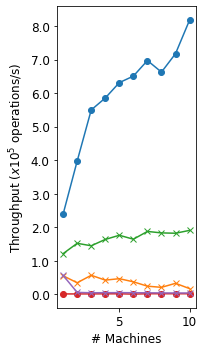

In [62]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_throughput_mean=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Streaming Metrics HDRF 8/", metric_name="throughput"),agg="mean"))
windowed_throughput_mean=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Windowed Metrics HDRF 2/", metric_name="throughput"),agg="mean"))
count_window_throughput_mean = transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/CountWindowMetrics/", metric_name="throughput"),agg="mean"))
# streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_throughput_mean, windowed_throughput_mean, count_window_throughput_mean, DGL_STREAMING_MEAN_THROUGHPUT, DGL_WINDOWED_MEAN_THROUGHPUT],["D3-GNN Streaming", "D3-GNN Windowed-200ms", "D3-GNN Windowed-2000", "DGL Streaming", "DGL Windowed-2000"], ["o", "x","x", "o", "x"], ["-","-","-","-","-"], [None, None, None, None, None], xlabel="# Machines")
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["RF (HDRF-8)"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
#ax.legend(fontsize=12)
plt.rcParams["figure.figsize"] = (3,5)

(0.0, 1.0, 0.0, 1.0)

/home/rustambaku13/miniconda3/envs/flink/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


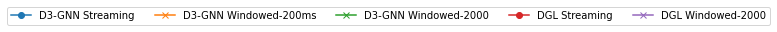

In [63]:
# for legend separately
figsize = (5, 0.3)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', ncol=5)
# hide the axes frame and the x/y labels
ax_leg.axis('off')

/home/rustambaku13/miniconda3/envs/flink/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


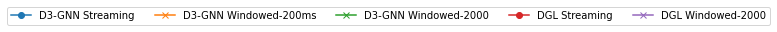

In [67]:
fig_leg

In [71]:
fig_leg.savefig("../../jupyter/plots/legend-stream-windowed.png")

/tmp/ipykernel_7554/2077610988.py:1: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_leg.tight_layout()
/tmp/ipykernel_7554/2077610988.py:2: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_leg.savefig("../../jupyter/plots/legend-stream-windowed.png")


### Reddit Max Throughput

/tmp/ipykernel_7554/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


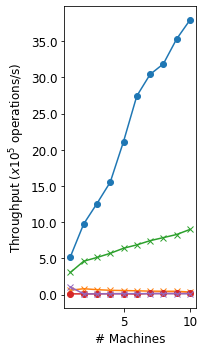

In [57]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_throughput_max=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Streaming Metrics HDRF 8/",metric_name="throughput"),agg="max"))
windowed_throughput_max=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Windowed Metrics HDRF 2/",metric_name="throughput"),agg="max"))
count_window_throughput_max = transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/CountWindowMetrics/", metric_name="throughput"),agg="max"))
# streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_throughput_max, windowed_throughput_max, count_window_throughput_max, DGL_STREAMING_MAX_THROUGHPUT, DGL_WINDOWED_MAX_THROUGHPUT],["D3-GNN Streaming", "D3-GNN Windowed-200ms", "D3-GNN Windowed-2kcount", "DGL Streaming", "DGL_Window_mean"], ["o", "x","x", "o", "x"], ["-","-","-","-","-"], [None, None, None, None, None], xlabel="# Machines")
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["RF (HDRF-8)"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
#ax.legend()
plt.rcParams["figure.figsize"] = (3,5)

In [13]:
fig.savefig("../figures/throughput_max_reddit_hdrf_8.png")

### StackOverflow Throughput Mean

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


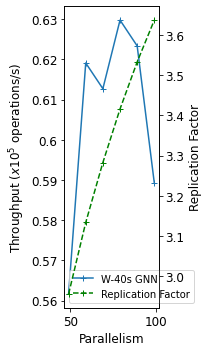

In [14]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
windowed_thoughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="throughput"),agg="mean")
streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [windowed_thoughput_mean],["W-40s GNN"], ["+"], ["-"], [None])
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["Replication Factor"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)


### StackOverflow Throughput Max

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


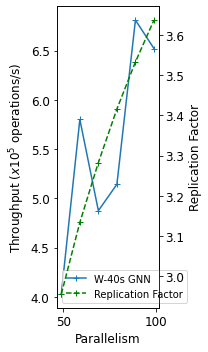

In [15]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
windowed_thoughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="throughput"),agg="max")
streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [windowed_thoughput_mean],["W-40s GNN"], ["+"], ["-"], [None])
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["Replication Factor"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)


### Partitioner Throughput Max Streaming Reddit

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


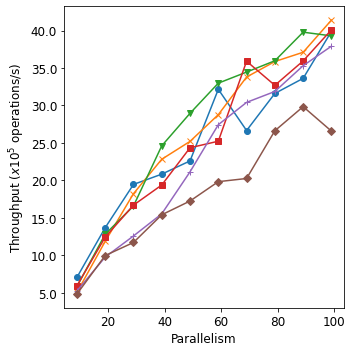

In [122]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_hdrf_0_5=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/",metric_name="throughput"),agg="max")
streaming_hdrf_1=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 1/",metric_name="throughput"),agg="max")
streaming_hdrf_2=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/",metric_name="throughput"),agg="max")
streaming_hdrf_8=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/",metric_name="throughput"),agg="max")
streaming_hdrf_4=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/",metric_name="throughput"),agg="max")
streaming_random=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/",metric_name="throughput"),agg="max")
streaming_replication_factor_0_5 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_1 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_2 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_4 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_8 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_random = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/", operator_name="Random Partitioner", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_hdrf_0_5,streaming_hdrf_1,streaming_hdrf_2, streaming_hdrf_4,streaming_hdrf_8,streaming_random],["HDRF-0.5","HDRF-1","HDRF-2", "HDRF-4","HDRF-8", "Random"], ["o","x", "v", "s", "+","D"], ["-","-","-","-","-","-"], [None,None, None, None, None, None])
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor_0_5,streaming_replication_factor_1, streaming_replication_factor_2,streaming_replication_factor_4, streaming_replication_factor_8,streaming_replication_factor_random],["RF (hdrf-0.5)","RF (hdrf-1)","RF (hdrf-2)","RF (hdrf-4)", "RF (hdrf-8)", "RF (random)"], ["o","x", "v", "s", "+","D"], ["--","--","--","--","--","--"],['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown'], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
#for l in lines2:
#    l.set_alpha(0.4)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
plt.rcParams["figure.figsize"] = (5,5)

<ipython-input-17-10afd0333e2c>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig_leg.savefig("../figures/legend-partitioner-comparison.png")
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


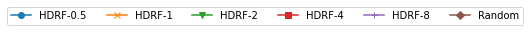

In [17]:
# for legend separately
figsize = (7.5, 0.3)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
lines = lines1 
labs = [l.get_label() for l in lines]
ax_leg.legend(lines, labs, loc='center',ncol=6)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig("../figures/legend-partitioner-comparison.png")

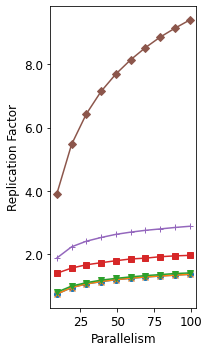

In [120]:
fig2, ax2, lines2 = plot_aggregated_dict(None, [streaming_replication_factor_0_5,streaming_replication_factor_1, streaming_replication_factor_2,streaming_replication_factor_4, streaming_replication_factor_8,streaming_replication_factor_random],["RF (hdrf-0.5)","RF (hdrf-1)","RF (hdrf-2)","RF (hdrf-4)", "RF (hdrf-8)", "RF (random)"], ["o","x", "v", "s", "+","D"],["-","-","-","-","-","-"],['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown'], ylabel="Replication Factor", formatter=yfmt2)
#ax.legend(lines, labs, loc=0)
plt.rcParams["figure.figsize"] = (3,5)

In [123]:
fig.savefig("../figures/throughput_max_reddit_partitioner_comparison.png")
fig2.savefig("../figures/replication_factor_reddit_partitioner_comparison.png")

<ipython-input-6-edf2ff55d446>:15: RuntimeWarning: Mean of empty slice
  tmp_exp.append(np.nanmean(np.where(exp_values == 0, np.nan, exp_values), axis=0)) # Sum across sub operators
<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


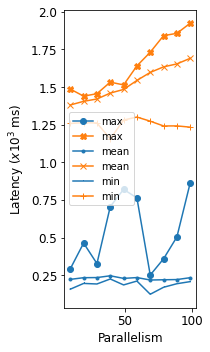

In [54]:
streaming_latency_max= agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Streaming/",operator_name="GNN Operator - 2", metric_name="latency"), agg="max", agg_sub_op="mean")
windowed_latency_max=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Windowed/",operator_name="GNN Operator - 2", metric_name="latency"),agg="max", agg_sub_op="mean")
streaming_latency_mean= agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Streaming/",operator_name="GNN Operator - 2", metric_name="latency"), agg="mean", agg_sub_op="mean")
windowed_latency_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Windowed/",operator_name="GNN Operator - 2", metric_name="latency"),agg="mean", agg_sub_op="mean")
streaming_latency_min= agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Streaming/",operator_name="GNN Operator - 2", metric_name="latency"), agg="min", agg_sub_op="mean")
windowed_latency_min=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Latency Metrics Windowed/",operator_name="GNN Operator - 2", metric_name="latency"),agg="min", agg_sub_op="mean")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_latency_max, windowed_latency_max,streaming_latency_mean, windowed_latency_mean,streaming_latency_min, windowed_latency_min],["max", "max", "mean", "mean", "min", "min"], ["o","X", ".", "x", ",", "+"], ["-", "-","-", "-","-", "-"], ['tab:blue','tab:orange','tab:blue','tab:orange','tab:blue','tab:orange'], ylabel="Latency ($x10^3$ ms)", formatter=yfmt2)
plt.rcParams["figure.figsize"] = (3,5)
plt.legend()

In [55]:
fig.savefig("../figures/latency_reddit.png")

# Runtime Plots

### Reddit Runtime

/tmp/ipykernel_7554/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


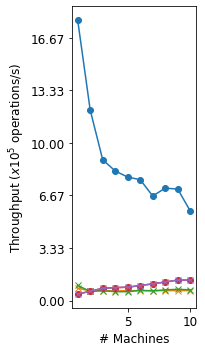

In [72]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_runtime=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Streaming Metrics HDRF 8/",metric_name="numRecordsOut"),agg="len_nonzero"))
windowed_runtime=transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/Windowed Metrics HDRF 2/",metric_name="numRecordsOut"),agg="len_nonzero"))
count_window_runtime = transform_parallel_to_machines(agg_concat_list(get_aggregated_throughput(entry_folder_name="../../jupyter/metrics/CountWindowMetrics/", metric_name="numRecordsOut"),agg="len_nonzero"))
#streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_runtime, windowed_runtime, count_window_runtime, DGL_WINDOWED_RUNTIME, DGL_WINDOWED_RUNTIME],["D3-GNN Streaming", "D3-GNN Windowed-200ms", "D3-GNN Windowed-2kcount", "DGL Streaming", "DGL_Window_mean"], ["o", "x","x", "o", "x"], ["-","-","-","-","-"], [None, None, None, None, None], xlabel="# Machines", formatter=sec_to_min)
#fig, ax, lines1 = plot_aggregated_dict(None, [streaming_throughput_mean],["Streaming"], ["o"], ["-"], [None], ylabel="Runtime ($x10^{-3}$ mins): Streaming")
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [windowed_throughput_mean],["Windowed-200ms"], ["x"], ["-"], ["tab:orange"], pre_fig=(fig,ax2), ylabel="Runtime ($10^{-2}$ mins): Windowed-200ms", formatter=yfmt4)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
plt.rcParams["figure.figsize"] = (3,5)

In [74]:
fig.savefig("../../jupyter/plots/runtime_reddit_hdrf_8.png")

### StackOverflow Runtime

/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_26064/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


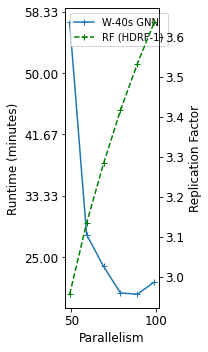

In [33]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
windowed_thoughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [windowed_thoughput_mean],["W-40s GNN"], ["+"], ["-"], [None], ylabel="Runtime (minutes)", formatter=sec_to_min)
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["RF (HDRF-1)"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)


In [34]:
windowed_thoughput_mean

{69: 1424, 59: 1684, 89: 1198, 49: 3416, 79: 1208, 99: 1298}

In [23]:
fig.savefig("../figures/runtime_stackoverflow_hdrf_1.png")

### Partitioner Runtime Streaming Reddit

/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_26064/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


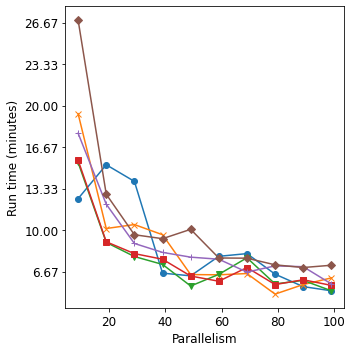

In [8]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_hdrf_0_5=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_hdrf_1=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 1/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_hdrf_2=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_hdrf_8=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_hdrf_4=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_random=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/",metric_name="numRecordsOut"),agg="len_nonzero")
streaming_replication_factor_0_5 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_2 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_8 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_4 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_random = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/", operator_name="Random Partitioner", metric_name="Replication Factor"),agg="last_nonzero")
#fig, ax, lines1 = plot_aggregated_dict(None, [streaming_hdrf_0_5,streaming_hdrf_1, streaming_hdrf_2, streaming_hdrf_4,streaming_hdrf_8,streaming_random],["HDRF-0.5","HDRF-2", "HDRF-4","HDRF-8", "Random"], ["o","x", "v", "s", "+","D"], ["-","-","-","-","-"], [None, None, None, None, None], ylabel="Run time (minutes)", formatter=sec_to_min)
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_hdrf_0_5,streaming_hdrf_1,streaming_hdrf_2, streaming_hdrf_4,streaming_hdrf_8,streaming_random],["HDRF-0.5","HDRF-1","HDRF-2", "HDRF-4","HDRF-8", "Random"], ["o","x", "v", "s", "+","D"], ["-","-","-","-","-","-"], [None,None, None, None, None, None],ylabel="Run time (minutes)", formatter=sec_to_min)
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor_0_5, streaming_replication_factor_2,streaming_replication_factor_4, streaming_replication_factor_8,streaming_replication_factor_random],["RF (hdrf-0.5)","RF (hdrf-2)","RF (hdrf-4)", "RF (hdrf-8)", "RF (random)"], ["+","+","+","+","+"], ["--","--","--","--","--"],["m","g","b","c", "r"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
#for l in lines2:
#    l.set_alpha(0.4)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
plt.rcParams["figure.figsize"] = (5,5)

In [15]:
fig.savefig("../figures/runtime_reddit_partitioner_comparison.png")

# Iteration Message Volume


### Layer 2 Reddit

/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_26064/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


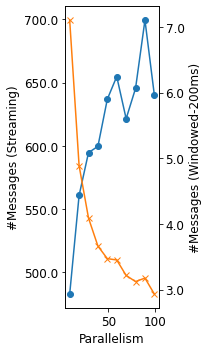

In [37]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_throughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
windowed_throughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed Metrics HDRF 2/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
#streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
#fig, ax, lines1 = plot_aggregated_dict(None, [streaming_throughput_mean, windowed_throughput_mean],["Streaming", "Windowed-200ms"], ["o", "x"], ["-","-"], [None, None], ylabel="$\log_2$(#Messages)")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_throughput_mean],["Streaming"], ["o"], ["-"], [None], ylabel="#Messages (Streaming)")
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [windowed_throughput_mean],["Windowed-200ms"], ["x"], ["-"], ["tab:orange"], pre_fig=(fig,ax2), ylabel="#Messages (Windowed-200ms)")
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
#ax.legend(fontsize=12)
plt.rcParams["figure.figsize"] = (3,5)

In [38]:
streaming_throughput_mean,windowed_throughput_mean

({39: 59959926,
  29: 59463974,
  49: 63691258,
  89: 69948103,
  9: 48274348,
  99: 64010212,
  69: 62149746,
  79: 64548601,
  19: 56076915,
  59: 65484288},
 {89: 317603,
  59: 345186,
  79: 312289,
  39: 366313,
  9: 710209,
  49: 347185,
  29: 408987,
  19: 488649,
  99: 293225,
  69: 321569})

In [104]:
fig.savefig("../figures/comm_volume_reddit_layer_1.png")

### Layer 1-2 StackOverflow

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


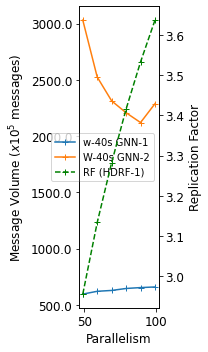

In [28]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
windowed_thoughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
windowed_thoughput_mean_1=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 1"),agg="max")
streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [windowed_thoughput_mean_1, windowed_thoughput_mean],["w-40s GNN-1","W-40s GNN-2"], ["+","+"], ["-","-"], [None, None], ylabel="Message Volume ($x 10^5$ messages)")
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["RF (HDRF-1)"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)


In [29]:
fig.savefig("../figures/volume_stackoverflow_layer_1_2.png")

### Partitioner Comparison

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


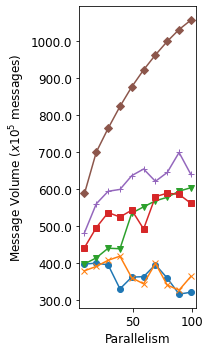

In [30]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
streaming_hdrf_0_5=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_hdrf_1=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 1/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_hdrf_2=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_hdrf_8=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_hdrf_4=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_random=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/",metric_name="numRecordsOut",operator_name="Source: IterationHead - 2"),agg="max")
streaming_replication_factor_0_5 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 0.5/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_1 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_2 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 2/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_4 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 4/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_8 = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics HDRF 8/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
streaming_replication_factor_random = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Streaming Metrics Random/", operator_name="Random Partitioner", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_hdrf_0_5,streaming_hdrf_1,streaming_hdrf_2, streaming_hdrf_4,streaming_hdrf_8,streaming_random],["HDRF-0.5","HDRF-1","HDRF-2", "HDRF-4","HDRF-8", "Random"], ["o","x", "v", "s", "+","D"],["-","-","-","-","-","-"], [None,None, None, None, None, None], ylabel="Message Volume ($x 10^5$ messages)")
#ax2 = ax.twinx()
#_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor_0_5,streaming_replication_factor_1, streaming_replication_factor_2,streaming_replication_factor_4, streaming_replication_factor_8,streaming_replication_factor_random],["RF (hdrf-0.5)","RF (hdrf-1)","RF (hdrf-2)","RF (hdrf-4)", "RF (hdrf-8)", "RF (random)"], ["o","x", "v", "s", "+","D"],["-","-","-","-","-","-"],['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown'], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
#for l in lines2:
#    l.set_alpha(0.4)
#lines = lines1 + lines2
#labs = [l.get_label() for l in lines]
#ax.legend(lines, labs, loc=0)
plt.rcParams["figure.figsize"] = (5,5)

In [31]:
fig.savefig("../figures/comm_volume_reddit_layer_1_2_partitioner_comparison.png")

# Fan-In Message Volume

<ipython-input-6-edf2ff55d446>:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)


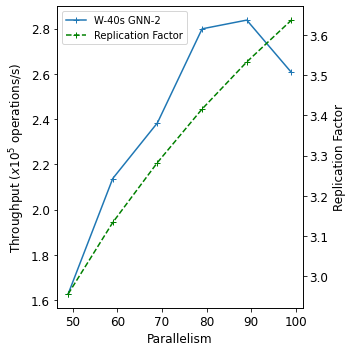

In [32]:
# streaming_throughput_max=get_aggregated_throughput(entry_folder_name="../streaming_throughput_1_10",metric_name="throughput", agg="max")
windowed_thoughput_mean=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/",metric_name="numRecordsInPerSecond",operator_name="GNN Operator - 0"),agg="mean")
streaming_replication_factor = agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Windowed StackOverflow HDRF 1/", operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor"),agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [windowed_thoughput_mean],["W-40s GNN-2"], ["+"], ["-"], [None])
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_replication_factor],["Replication Factor"], ["+"], ["--"],["g"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=yfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)


In [33]:
fig.savefig("../figures/message_volume_partitioning.png")

# Lambda Metrics

/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_26064/1608438555.py:19: RuntimeWarning: Mean of empty slice
  tmp_exp_mean = np.nanmean(np.where(tmp_exp == 0, np.nan, tmp_exp), axis=0)
/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_26064/1977783588.py:8: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1091dc8b0> has a label of '_child1' which cannot be automatically added to the legend.
  ax.legend(lines, labs,loc="lower right")


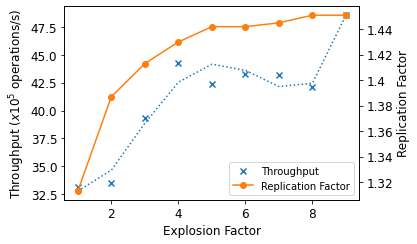

In [40]:
streaming_lambda_throughputs=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Lambda Metrics Streaming HDRF 2/",operator_name="GNN Operator - 2", metric_name="throughput", is_lambda=True), agg="max")
streaming_lambda_rf=agg_concat_list(get_aggregated_throughput(entry_folder_name="../metrics/Lambda Metrics Streaming HDRF 2/",operator_name="HDRF-Partitioner-10Threads", metric_name="Replication Factor", is_lambda=True), agg="last_nonzero")
fig, ax, lines1 = plot_aggregated_dict(None, [streaming_lambda_throughputs],["Throughput"], ["x"], ["-"], [None], xlabel="Explosion Factor",fit_degree=4)
ax2 = ax.twinx()
_, _, lines2 = plot_aggregated_dict(None, [streaming_lambda_rf],["Replication Factor"], ["o"], ["-"],["tab:orange"], ylabel="Replication Factor", pre_fig=(fig,ax2), formatter=numfmt2)
lines = lines1 + lines2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs,loc="lower right")
plt.rcParams["figure.figsize"] = (6,3.5)

In [41]:
fig.savefig("../figures/lambda_throughput.png")

In [36]:
streaming_lambda_throughputs[2][0][0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13143.0,
 13143.0,
 13143.0,
 13143.0,
 13143.0,
 8512.0,
 8512.0,
 8512.0,
 8512.0,
 8512.0,
 5901.0,
 5901.0,
 5901.0,
 5901.0,
 5901.0,
 4052.0,
 4052.0,
 4052.0,
 4052.0,
 4052.0,
 3159.0,
 3159.0,
 3159.0,
 3159.0,
 3159.0,
 2935.0,
 2935.0,
 2935.0,
 2935.0,
 2935.0,
 1212.0,
 1212.0,
 1212.0,
 1212.0,
 1212.0,
 1523.0,
 1523.0,
 1523.0,
 1523.0,
 1523.0,
 1258.0,
 1258.0,
 1258.0,
 1258.0,
 1258.0,
 1532.0,
 1532.0,
 1532.0,
 1532.0,
 1532.0,
 1685.0,
 1685.0,
 1685.0,
 1685.0,
 1685.0,
 1343.0,
 1343.0,
 1343.0,
 1343.0,
 1343.0,
 1547.0,
 1547.0,
 1547.0,
 1547.0,
 1547.0,
 1422.0,
 1422.0,
 1422.0,
 1422.0,
 1422.0,
 1397.0,
 1397.0,
 1397.0,
 1397.0,
 1397.0,
 867.0,
 867.0,
 867.0,
 867.0,
 867.0,
 949.0,
 949.0,
 949.0,
 949.0,
 949.0,
 894.0,
 894.0,
 894.0,
 894.0,
 894.0,
 902.0,
 902.0,
 902.0,
 902.0,
 902.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 1265.0,
 953.0,
 953.0,
 953.0,
 953.0,
 953.0,
 1211.0,
 1211.0,
 1211.0,
